In [1]:
import os
import string

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%pylab inline
os.chdir("..")

Populating the interactive namespace from numpy and matplotlib


## Import Data

In [2]:
from src import URL_TITANIC
from src.obtain import get_raw_data, json_write

df = get_raw_data(url=URL_TITANIC)

# Scrub Data

In [3]:
print("Declaring an empty dictionary to persist information we'll need to scrub new data in production.")
dict_scrub_steps = {}

Declaring an empty dictionary to persist information we'll need to scrub new data in production.


### Column Names

In [4]:
df.columns

Index(['passenger class', 'survived', 'name', 'AGE', 'Siblings/Spouses Aboard',
       'par&ch', 'ticket', 'fare', 'cabin Number', 'embarked'],
      dtype='object')

In [5]:
remove_ = str.maketrans(dict.fromkeys(string.punctuation + ' '))

print("Fixing column names. (Removing special characters, converting to lowercase. Renaming long columns)")
df.columns = map(lambda i: i.lower().translate(remove_), 
                 df.columns.tolist())

df.rename(columns={'siblingsspousesaboard': 'sibsp'}, inplace=True)

Fixing column names. (Removing special characters, converting to lowercase. Renaming long columns)


In [6]:
df.columns

Index(['passengerclass', 'survived', 'name', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabinnumber', 'embarked'],
      dtype='object')

### Missings

In [7]:
have_missing = \
(df
 .isnull()
 .sum()
 .where(lambda x: x > 0)
 .dropna()
 .index
 .tolist()
)

print("The following columns have missing data: \n{}".format(have_missing))

The following columns have missing data: 
['age', 'fare', 'cabinnumber', 'embarked']


In [8]:
dict_scrub_steps['have_missing'] = have_missing

In [9]:
pd.DataFrame({
    'type': df[have_missing].dtypes,
    'perc_missing': df[have_missing].isnull().mean().round(2),
    'num_missing': df[have_missing].isnull().sum()
})

,num_missing,perc_missing,type
age,263,0.20,float64
fare,1,0.00,float64
cabinnumber,1014,0.77,object
embarked,2,0.00,object


### Create Flags for Missing

In [10]:
for COL in have_missing:
    """
    Create a missing flag for each column
    that has missing data.
    """
    newCOL = COL + '__is_null'
    df.loc[:, newCOL] = df.loc[:, COL].isnull().astype(int)

### Impute Missings

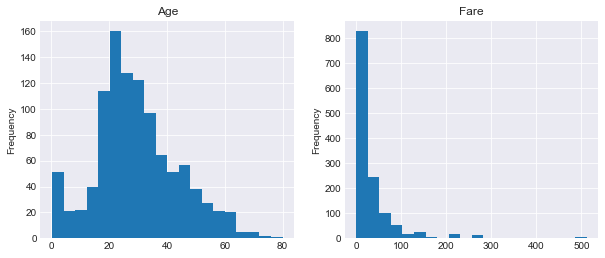

In [11]:
# impute missings
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

df['age'].plot.hist(bins=20, ax=ax[0], title='Age')
df['fare'].plot.hist(bins=20, ax=ax[1], title='Fare');

In [12]:
print("Age is approximately normally distributed, but Fare is skewed.")
print("Using the mean for Age and Median for Fare to impute missing data.")
print("Cabin Number has over 70% values missing. Dropping this variable.")
print("Embarked has only 2 values missing. Imputing with Mode.")

age_fillna = df['age'].mean()
fare_fillna = df['fare'].median()
embarked_fillna = df['embarked'].describe()['top']

df['age'].fillna(value=age_fillna, inplace=True)
df['fare'].fillna(value=fare_fillna, inplace=True)
df['embarked'].fillna(value=embarked_fillna, inplace=True)

Age is approximately normally distributed, but Fare is skewed.
Using the mean for Age and Median for Fare to impute missing data.
Cabin Number has over 70% values missing. Dropping this variable.
Embarked has only 2 values missing. Imputing with Mode.


In [13]:
dict_scrub_steps['age_fillna'] = age_fillna
dict_scrub_steps['fare_fillna'] = fare_fillna
dict_scrub_steps['embarked_fillna'] = embarked_fillna

### Create new columns

In [14]:
print("Creating a column for Gender")
df.loc[:, 'gender'] = df['name'].map(lambda i: 1 if 'Miss' in i or 'Mrs' in i else 0)

Creating a column for Gender


In [15]:
print("Creating Dummies for Embarked and Passenger Class. \nDone. Now dropping these.")

df = df.join(pd.get_dummies(df['embarked'], prefix='embarked'))
df = df.join(pd.get_dummies(df['passengerclass'], prefix='pclass'))

df.drop(['embarked', 'passengerclass'], axis=1, inplace=True)

Creating Dummies for Embarked and Passenger Class. 
Done. Now dropping these.


### Remove Zero Variance Columns

In [16]:
nzv_numeric = \
(df
 .select_dtypes(include=np.number)
 .std()
 .where(lambda i: i == 0)
 .dropna()
 .index
 .tolist()
)

In [17]:
nzv_string = \
(df
 .select_dtypes(include=object)
 .apply(lambda c: c.value_counts(normalize=True).max())
 .where(lambda i: i >= 0.97)
 .dropna()
 .index
 .tolist()
)

In [18]:
too_many_levels = \
(df
 .select_dtypes(include=object)
 .nunique()
 .where(lambda i: i/df.shape[0] > 32/df.shape[0])
 .index
 .tolist()
)

In [19]:
df.drop(nzv_numeric + nzv_string + too_many_levels, axis=1, inplace=True)

### Convert to numeric

In [20]:
from src.scrub import compress_numeric, compress_categorical

## Backup

In [21]:
cols_numeric = df.select_dtypes(include=np.number).columns

In [22]:
df_compressed = \
pd.concat([
    df.drop(cols_numeric, axis=1),
    df.select_dtypes(include=np.number).apply(compress_numeric)
], axis=1)

Downcasting survived to float
Downcasting survived to int
Downcasting age to float
Downcasting sibsp to int
Downcasting parch to int
Downcasting fare to float
Downcasting age__is_null to int
Downcasting fare__is_null to int
Downcasting cabinnumber__is_null to int
Downcasting embarked__is_null to int
Downcasting gender to int
Downcasting embarked_C to int
Downcasting embarked_Q to int
Downcasting embarked_S to int
Downcasting pclass_1 to int
Downcasting pclass_2 to int
Downcasting pclass_3 to int


## Backups

In [23]:
df_compressed.to_csv("data/04-processed/titanic.csv")

In [40]:
json_write(dict_scrub_steps, "data/02-interim/scrub_steps.json")